# Transfer learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about na new kind of tranfer learning: fine-tuning

In [1]:
# Check if we are using a GPU
!nvidia-smi

Wed Jun 12 01:16:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious

In [2]:
# Importing the helper.py script and its functionalities

!wget https://raw.githubusercontent.com/arrshsh/ML-and-DS/main/TensorFlow/helper_functions.py

--2024-06-12 01:16:38--  https://raw.githubusercontent.com/arrshsh/ML-and-DS/main/TensorFlow/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-12 01:16:38 (92.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2024-06-12 01:16:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 142.251.183.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   102MB/s    in 1.6s    

2024-06-12 01:16:46 (102 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and tes directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size =BATCH_SIZE) # This is an updated version of generating training and testing sets
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                               image_size = IMG_SIZE,
                                                               label_mode = "categorical",
                                                               batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[165.84694   160.84694   104.84694  ]
   [166.42857   161.42857   106.42857  ]
   [165.56633   157.56633   108.9949   ]
   ...
   [206.42859   208.21432   169.00006  ]
   [206.28572   207.28572   175.28572  ]
   [207.54085   207.54085   179.54085  ]]

  [[169.02551   164.02551   109.025505 ]
   [164.06633   157.06633   103.06632  ]
   [167.62755   159.18367   110.22959  ]
   ...
   [205.28569   206.87247   169.51535  ]
   [209.06635   210.06635   178.06635  ]
   [208.31116   208.90807   179.11734  ]]

  [[168.86734   162.86734   104.01021  ]
   [170.85715   164.42857   105.57143  ]
   [168.59694   159.38264   103.09694  ]
   ...
   [204.38263   205.78574   169.16841  ]
   [206.78572   207.78572   175.78572  ]
   [206.58162   207.58162   176.58162  ]]

  ...

  [[188.48975   190.20912   128.051    ]
   [184.30095   189.30095   123.44381  ]
   [186.5204    191.5204    124.5204   ]
   ...
   [216.21426   215.66328   163.40312  ]
   [214.12752   214.14282   161.5561   ]
   [2

## Model 0: Building a transfer learning feature extraction model using Keras Fucntional API

The sequential API is straight-forward, it runs our layers in a sequential order.

But the functional API gives more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False) # The false herein means that we are not invluding the top layer. We will add our own layer

# 2. Freeze the base model (so the pre-trained ) patterns remain
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224,224,3), name= "input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
# Check the data shape after passing it to the base model
print(f"Shape after base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name= "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                 experiment_name = "10_percent_feature_extraction")])

24274472/24274472 [==============================] - 0s 0us/step
Shape after base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240612-011709
Epoch 1/5
24/24 [==============================] - 23s 388ms/step - loss: 1.9734 - accuracy: 0.3533 - val_loss: 1.3791 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - 7s 286ms/step - loss: 1.2101 - accuracy: 0.7160 - val_loss: 0.9344 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 5s 173ms/step - loss: 0.8896 - accuracy: 0.7880 - val_loss: 0.7388 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 5s 174ms/step - loss: 0.7253 - accuracy: 0.8520 - val_loss: 0.6284 - val_accuracy: 0.8701
Epoch 5/5
24/24 [==============================] - 5s 180ms/step - loss: 0.6090 - accuracy: 0.8733 - val_loss: 0.5849 - val_accuracy: 0.8750


In [12]:
# The accuracy for the training and validation set is only for quarter of the data. Now, let us evaluate it on the full data
model_0.evaluate(test_data)

79/79 [==============================] - 8s 97ms/step - loss: 0.5824 - accuracy: 0.8648


[0.5823559761047363, 0.864799976348877]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# Summary of our base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [15]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

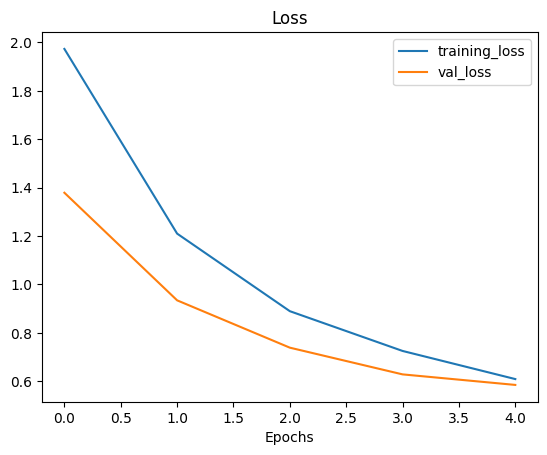

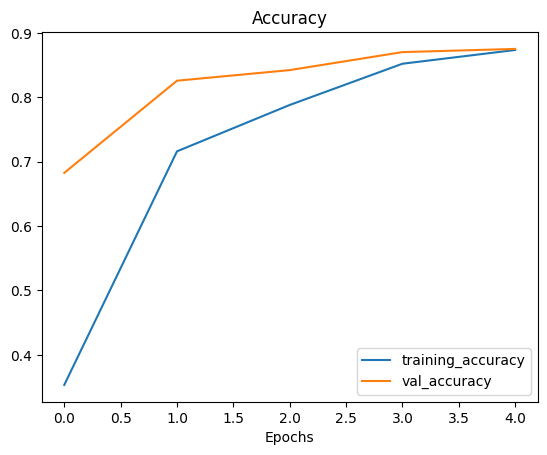

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor} \n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]] 

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data? In the following sections, we'll set up a bunch of experiments to work on while using transfer learning:

1. `model_1`: Use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation.

> **Note:** Throughout all experiments same test dataset will be used to evaluate our model, this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [19]:
 # Download and unzip data- preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2024-06-12 01:18:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 172.217.214.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  48.8MB/s    in 2.6s    

2024-06-12 01:18:21 (48.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Creating training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [22]:
# Setup data loaders
IMG_SIZE = (224,224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
print(tf.__version__)

2.15.0


## Adding data augmentation into the model

To add data augmentation right into out models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Benifits of doing this: [Link](https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers)

* While ImageDataGenerator load images by using CPU, the augmentation layer does so by using a GPU.
* Image data augmentation happens only during training, so we can export the model with all the info

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1.0/255) #Keep this for models like ResNet but remove it while using EfficientNet
], name = "data_augmentation")

### Visualize our data augmentation layer ( and see what happens to our data )

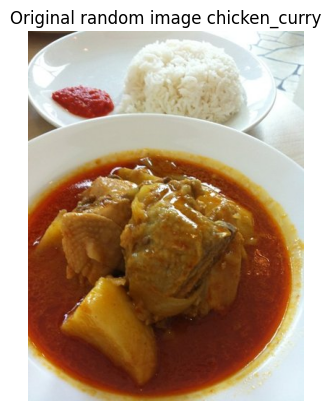

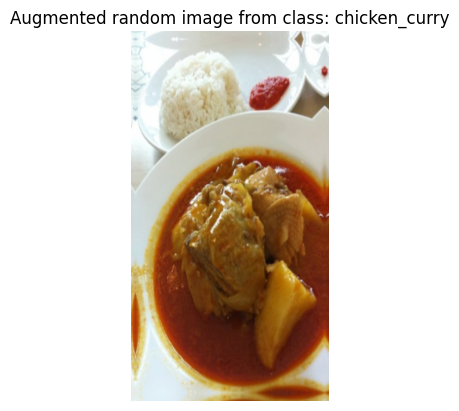

In [25]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image {target_class}")
plt.axis(False);

# Now let's plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure() # making a new plt.figure() as we already used the previous one
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

 ## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [26]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation Sequential model as a lyer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name= "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name= "output_layer")(x)

# When working with a layer, x is after one pair of braces. When working with models, x is in the first pair of the brackets

# Make a model using inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = 0.25*len(test_data), #This line means we are validating on only 25% of the testing data
                                #Track the model using callbacls
                                callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

16705208/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240612-011829
Epoch 1/5
3/3 [==============================] - 17s 3s/step - loss: 2.3380 - accuracy: 0.1143 - val_loss: 2.2427 - val_accuracy: 0.1953
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1001 - accuracy: 0.2571 - val_loss: 2.1120 - val_accuracy: 0.2609
Epoch 3/5
3/3 [==============================] - 6s 2s/step - loss: 1.9252 - accuracy: 0.4714 - val_loss: 1.9881 - val_accuracy: 0.3438
Epoch 4/5
3/3 [==============================] - 8s 3s/step - loss: 1.7172 - accuracy: 0.6143 - val_loss: 1.8857 - val_accuracy: 0.4281
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5726 - accuracy: 0.7143 - val_loss: 1.7809 - val_accuracy: 0.4906


In [27]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [28]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 97ms/step - loss: 1.7943 - accuracy: 0.4728


[1.7943181991577148, 0.47279998660087585]

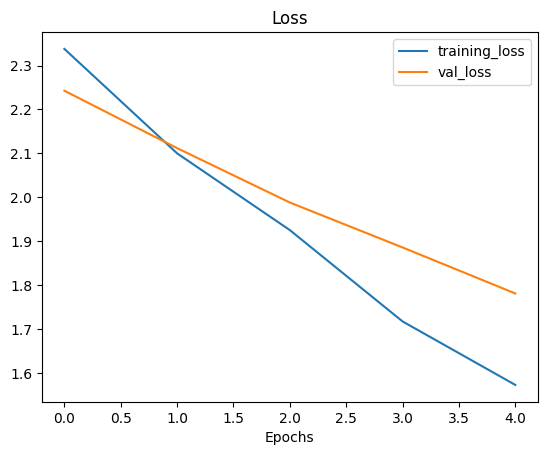

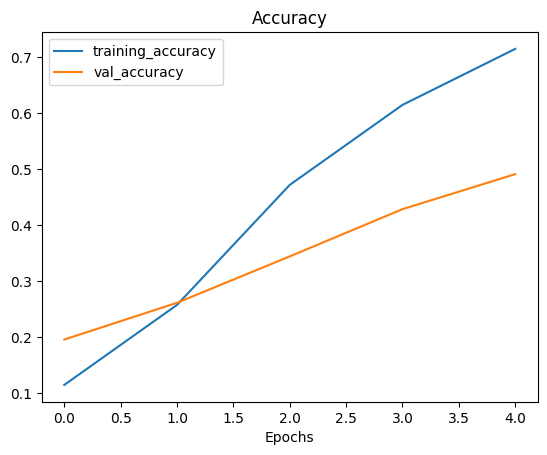

In [29]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [30]:
# Get 10% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

--2024-06-12 01:19:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 173.194.206.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   195MB/s    in 0.8s    

2024-06-12 01:19:25 (195 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
# Set data input
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [33]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

### Creating a model checkpoint callback

the ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This si useful so we can come and start where we left off.

In [34]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [35]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240612-011931
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0122 - accuracy: 0.3413
Epoch 1: val_loss improved from inf to 1.47637, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 42s 1s/step - loss: 2.0122 - accuracy: 0.3413 - val_loss: 1.4764 - val_accuracy: 0.6678
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4011 - accuracy: 0.6760
Epoch 2: val_loss improved from 1.47637 to 1.02036, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 27s 1s/step - loss: 1.4011 - accuracy: 0.6760 - val_loss: 1.0204 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.7400
Epoch 3: val_loss improved from 1.02036 to 0.81152, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=======

In [36]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 81ms/step - loss: 0.5824 - accuracy: 0.8648


[0.5823559165000916, 0.864799976348877]

In [37]:
# Check model_2 results on all data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 79ms/step - loss: 0.6518 - accuracy: 0.8372


[0.6517678499221802, 0.8371999859809875]

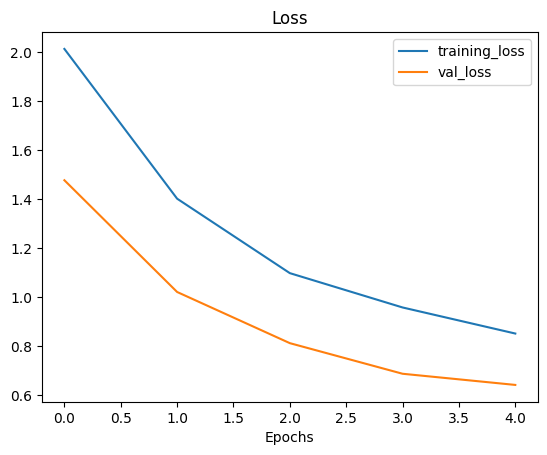

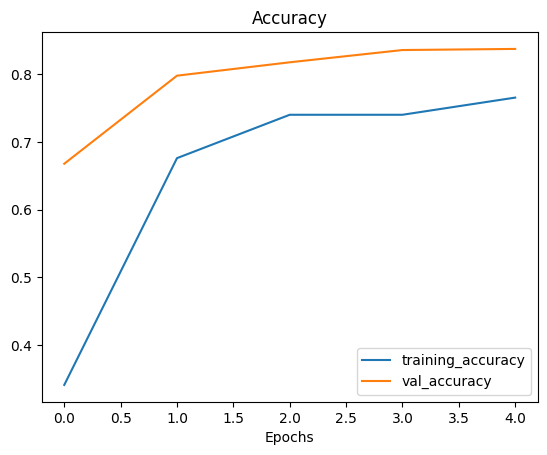

In [38]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

The plots are good. It indicates that if we keep on going, we might get a very good result!

### Loading in checkpointed weights

Loading in checkpinted weights returns a model to a specific checkpoint.

In [39]:
# Load in daved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [40]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.6518 - accuracy: 0.8372


In [41]:
# If the results from the previously evaluated model_2 matches the one with the loaded ones, it means that everything has worked so far
results_10_percent_data_aug == loaded_weights_model_results

False

In [42]:
# Check to see if laoded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [43]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug)- np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of data

> **Note**: Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

In [44]:
# Layers in loaded model
model_2.layers

In [45]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f03447c4310> True
<keras.src.engine.sequential.Sequential object at 0x7f033e1ce710> True
<keras.src.engine.functional.Functional object at 0x7f0344464b80> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f03447881c0> True
<keras.src.layers.core.dense.Dense object at 0x7f033e1e37c0> True


In [46]:
# What layers are there in the base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)


0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [47]:
# How many trainable variables are in out base model?
print(len(model_2.layers[2].trainable_variables))

0


In [48]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [49]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [50]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [51]:
print(len(model_2.trainable_variables))

12


In [52]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs= fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch= history_10_percent_data_aug.epoch[-1], #start training from previous last epoch
                                                    callbacks= [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                            experiment_name ="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240612-012226
Epoch 5/10
24/24 [==============================] - 35s 952ms/step - loss: 0.7318 - accuracy: 0.8013 - val_loss: 0.4867 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 19s 790ms/step - loss: 0.6056 - accuracy: 0.8053 - val_loss: 0.4108 - val_accuracy: 0.8586
Epoch 7/10
24/24 [==============================] - 18s 727ms/step - loss: 0.5490 - accuracy: 0.8307 - val_loss: 0.3851 - val_accuracy: 0.8668
Epoch 8/10
24/24 [==============================] - 18s 727ms/step - loss: 0.5092 - accuracy: 0.8307 - val_loss: 0.3875 - val_accuracy: 0.8635
Epoch 9/10
24/24 [==============================] - 21s 838ms/step - loss: 0.4749 - accuracy: 0.8467 - val_loss: 0.3885 - val_accuracy: 0.8618
Epoch 10/10
24/24 [==============================] - 17s 686ms/step - loss: 0.4440 - accuracy: 0.8573 - val_loss: 0.3847 - val_accuracy: 0.8783


In [53]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 63ms/step - loss: 0.4375 - accuracy: 0.8596


In [54]:
results_10_percent_data_aug

[0.6517678499221802, 0.8371999859809875]

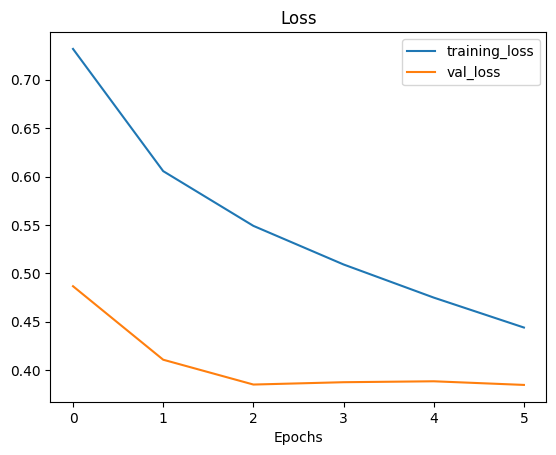

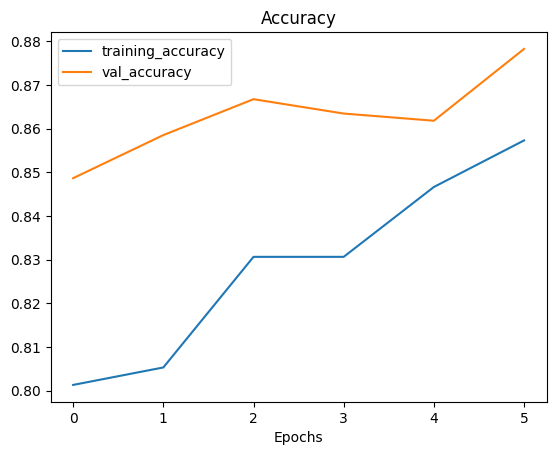

In [55]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [56]:
# Let's make a funciton to compare training histories
def compare_historys(original_history, new_history, intitial_epochs= 5):
  """
  Compare two TensorFlow History objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss +new_history.history["loss"]

  total_val_acc = acc + new_history.history["val_accuracy"]
  total_val_loss = loss +new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label = "Training Accuracy")
  plt.plot(total_val_acc, label = "Val Accuracy")
  plt.plot([initial_epochs -1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and validation accuracy")

  # Make plots for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label = "Training Loss")
  plt.plot(total_val_loss, label = "Val Loss")
  plt.plot([initial_epochs -1, initial_epochs - 1], plt.ylim(), label = "Start Fine Tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and validation loss")

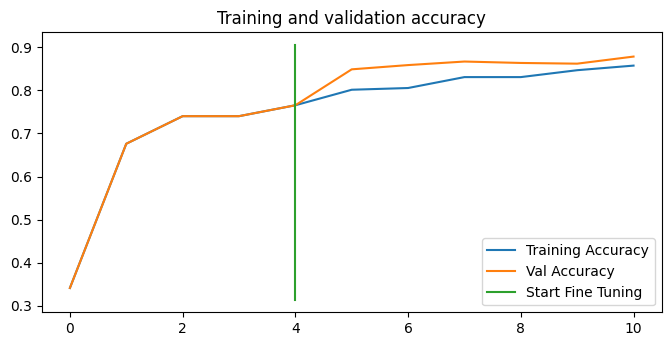

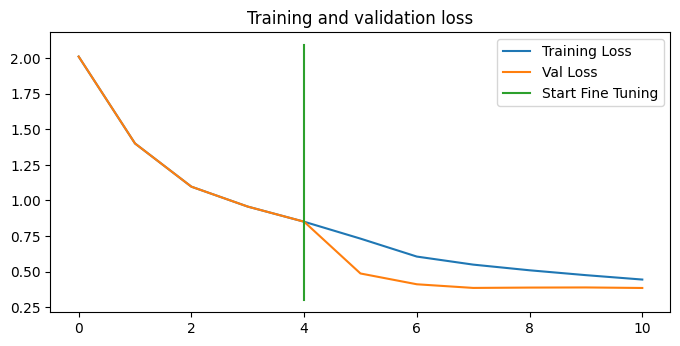

In [57]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug)

## Model 4: Fine-tuning an existing model on all of the data

In [58]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "/content/10_food_classes_all_data/train/"
test_dir = "/content/10_food_classes_all_data/test/"

--2024-06-12 01:25:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 142.250.125.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  73.9MB/s    in 6.6s    

2024-06-12 01:25:12 (74.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [59]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [60]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data we've loaded is the same as what we've been using for previous experiments (all experiments have used the same test dataset)

Let's verify this

In [61]:
results_fine_tune_10_percent

[0.4375450313091278, 0.8596000075340271]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [62]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = True

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [63]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [64]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [65]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240612-012526
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.3923 - accuracy: 0.1080
Epoch 1: val_loss improved from inf to 2.30441, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 135s 3s/step - loss: 2.3923 - accuracy: 0.1080 - val_loss: 2.3044 - val_accuracy: 0.1003
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 2.3163 - accuracy: 0.0933
Epoch 2: val_loss improved from 2.30441 to 2.30286, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 63s 3s/step - loss: 2.3163 - accuracy: 0.0933 - val_loss: 2.3029 - val_accuracy: 0.0773
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 2.3052 - accuracy: 0.1013
Epoch 3: val_loss did not improve from 2.30286
24/24 [==============================] - 61s 3s/step - loss: 2.3052 - accuracy: 0.1013 -

In [66]:
# Check model_2 results on all data
model_2.evaluate(test_data)

79/79 [==============================] - 6s 63ms/step - loss: 2.4200 - accuracy: 0.1000


[2.420015335083008, 0.10000000149011612]

Breaking downwhat we've done above:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weight using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same as step 2 except this time we're going to use all of the data (model_4).

In [67]:
# Freeze all layers except for the last 10
for layer in model_2.layers[2].layers[:-10]:
  layer.trainable = False

In [68]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [69]:
# Drilling into the base model to see which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [70]:
# Recompiling the model
model_2.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                metrics = ["accuracy"])

In [71]:
# Continue to traina dn fine-tune the model to the 100% of data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25*len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                    experiment_name = "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240612-013135
Epoch 5/10
235/235 [==============================] - 121s 465ms/step - loss: 2.3049 - accuracy: 0.0977 - val_loss: 2.3023 - val_accuracy: 0.1135
Epoch 6/10
235/235 [==============================] - 90s 381ms/step - loss: 2.3027 - accuracy: 0.1032 - val_loss: 2.3023 - val_accuracy: 0.1102
Epoch 7/10
235/235 [==============================] - 79s 336ms/step - loss: 2.3023 - accuracy: 0.1051 - val_loss: 2.3337 - val_accuracy: 0.1086
Epoch 8/10
235/235 [==============================] - 73s 309ms/step - loss: 2.3034 - accuracy: 0.1027 - val_loss: 2.3013 - val_accuracy: 0.1250
Epoch 9/10
235/235 [==============================] - 75s 319ms/step - loss: 2.3020 - accuracy: 0.1081 - val_loss: 2.3017 - val_accuracy: 0.1118
Epoch 10/10
235/235 [==============================] - 57s 237ms/step - loss: 2.3016 - accuracy: 0.0987 - val_loss: 2.3013 - val_accuracy: 0.1086


In [72]:
# Let's evaluate the model on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 61ms/step - loss: 2.3009 - accuracy: 0.1000


[2.3008573055267334, 0.10000000149011612]

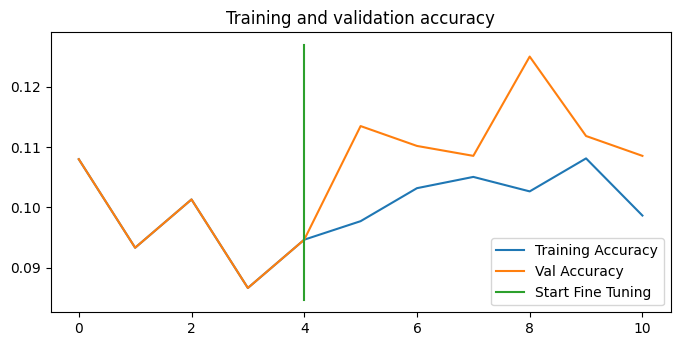

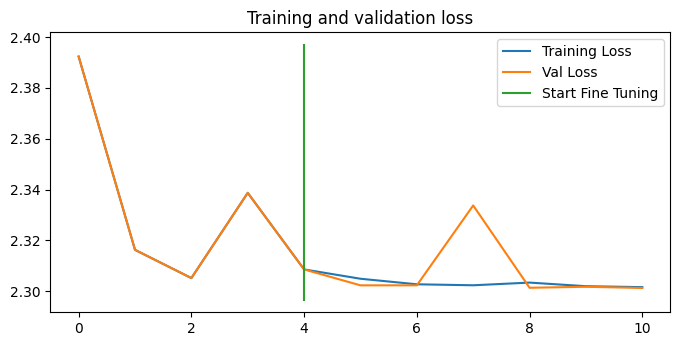

In [76]:
# How did fine-tuneing go with more data?
compare_historys(original_history = history_10_percent_data_aug,
                 new_history = history_fine_10_classes_full)